In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [7]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')
    plt.legend(prop={'size': 14})

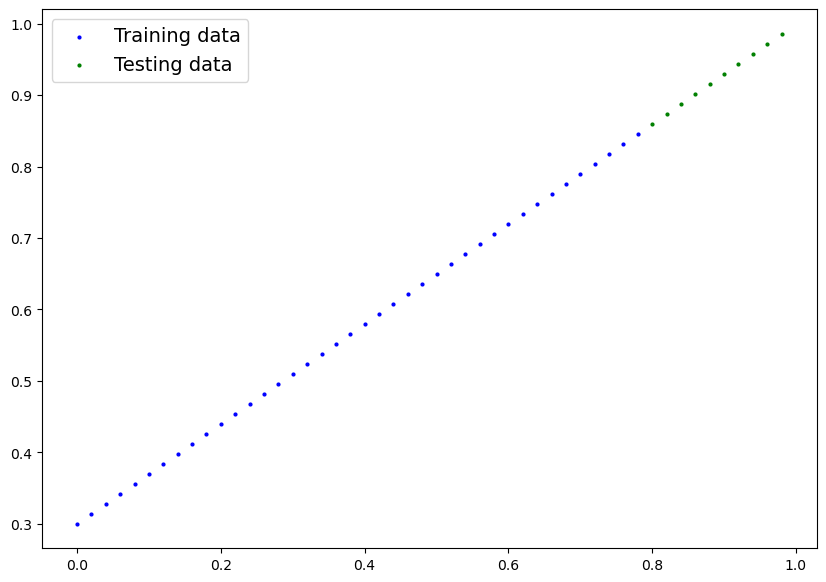

In [8]:
plot_predictions()

In [16]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # start with random weights
                                                dtype=torch.float),
                                    requires_grad=True) # update with gradient descent

        self.bias = nn.Parameter(torch.randn(1, # start with random bias
                                            dtype=torch.float),
                                requires_grad=True) # update with gradient descent
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data, like train/test features
        return self.weights * x + self.bias # linear regression y=m*x + b                                

torch.nn - contains building blocks for computational graphs\
torch.nn.Parameter - stores tensors that can be used with nn.Module\
torch.nn.Module - base class for neural network modules, all building blocks for neural networks are subclasses, requires forward()\
torch.optim - contains optimization algorithms for improving model parameters in nn.Parameter

In [22]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [23]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [25]:
# turns off stuff like gradient tracking which is unnecessary for just forward passing in inference to make it faster
with torch.inference_mode():
    y_preds = model_0(X_test)

In [26]:
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


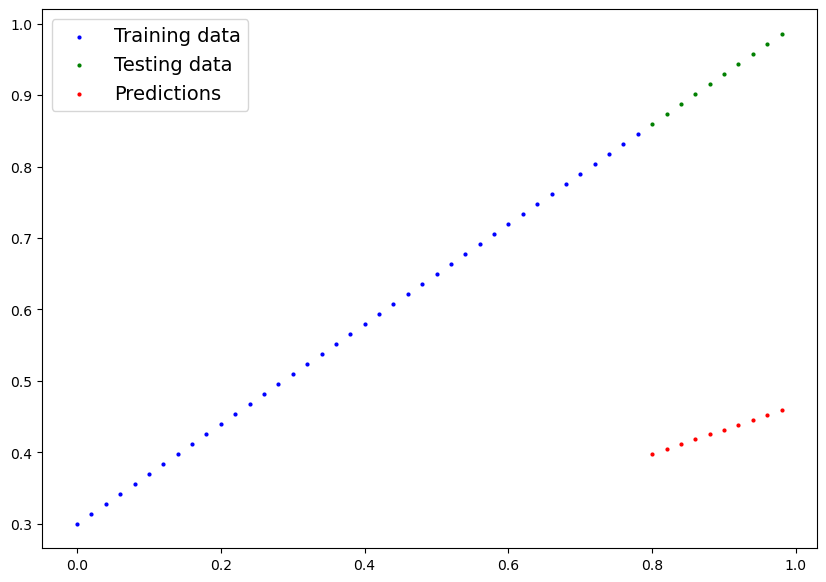

In [28]:
plot_predictions(predictions=y_preds)

In [29]:
# not so yay for random parameter values
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

loss function - in torch.nn, includes MAE and cross entropy\
optimizer - in torch.optim, includes SGD

In [30]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), # optimizing the weights and bias
                            lr=0.01) # hyperparameter learning rate